In [1]:
# look at tweets over time, quick statistics about content, etc

db_path = 'data/tweets_GILLUM/gillum_tweets_N1.db'
table_name = 'tweets'

import numpy as np
import math

import sqlite3
import pandas as pd

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from collections import defaultdict
from gensim.models import Word2Vec

from timeit import default_timer as timer

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import hdbscan


C:\Users\Brendan\Anaconda\envs\dimensionality_env\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# helper functions for getting metadata
# from - https://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html#printing-a-database-summary


def total_rows(cursor, my_table_name, print_out=False):
    """ Returns the total number of rows in the database """
    cursor.execute('SELECT COUNT(*) FROM {}'.format(my_table_name))
    count = cursor.fetchall()
    if print_out:
        print('\nTotal rows: {}'.format(count[0][0]))
    return count[0][0]

def table_col_info(cursor, table_name, print_out=False):
    """ Returns a list of tuples with column informations:
    (id, name, type, notnull, default_value, primary_key)
    """
    cursor.execute('PRAGMA TABLE_INFO({})'.format(table_name))
    info = cursor.fetchall()

    if print_out:
        print("\nColumn Info:\nID, Name, Type, NotNull, DefaultVal, PrimaryKey")
        for col in info:
            print(col)
    return info


def clean_text(paragraph,the_stopwords):
    
    # todo modify this for twitter-specific cleaning (remove usernames? hyperlinks? RT  etc)
    
    clean_words = []
    words = paragraph.split()
    
    for word in words:
        
        word = word.lower()
        
        # pick off any leading punctuation or trailing punctuation
        finished_checking_prefix = False
        while not(finished_checking_prefix):
            try:
                this_char = word[0]
                if this_char in string.punctuation:
                    word = word[1:] # snip leading punctuation
                else:
                    finished_checking_prefix = True
            except:
                # no more characters to check
                finished_checking_prefix = True
        
        finished_checking_postfix = False
        while not(finished_checking_postfix):
            try:
                this_char = word[-1]
                if this_char in string.punctuation:
                    word = word[:-1] # snip trailing punctuation
                else:
                    finished_checking_postfix = True
            except:
                # no more characters to check
                finished_checking_postfix = True
        
        # could split on slashes to handle this case: e.g. structure/function...but first need to check for url structure
        #word = " ".join(word.split('/'))
        
        if not(word in the_stopwords):
            clean_words.append(word)

    # or, better, use textblob Word lemmatize
    clean_paragraph = " ".join(clean_words)
    
    # remove stop words

    
    return clean_paragraph # return paragraph with words separated by spaces and no generic punctuation

In [4]:
db = sqlite3.connect(db_path)
print('database connected')
# cursor method
cursor = db.cursor()
# get some metadata
total_rows(cursor, table_name, print_out=True)
print(table_col_info(cursor, table_name, print_out=True))



database connected

Total rows: 401408

Column Info:
ID, Name, Type, NotNull, DefaultVal, PrimaryKey
(0, 'id_str', 'TEXT', 0, None, 0)
(1, 'screen_name', 'TEXT', 0, None, 0)
(2, 'created_at', 'TIMESTAMP', 0, None, 0)
(3, 'status_text', 'TEXT', 0, None, 0)
(4, 'reply_count', 'INT', 0, None, 0)
(5, 'favorite_count', 'INT', 0, None, 0)
(6, 'quote_count', 'INT', 0, None, 0)
(7, 'retweet_count', 'INT', 0, None, 0)
(8, 'coordinates', 'TEXT', 0, None, 0)
(9, 'place_coordinates', 'TEXT', 0, None, 0)
(10, 'place_fullname', 'TEXT', 0, None, 0)
(11, 'data_freshness', 'INT', 0, None, 0)
[(0, 'id_str', 'TEXT', 0, None, 0), (1, 'screen_name', 'TEXT', 0, None, 0), (2, 'created_at', 'TIMESTAMP', 0, None, 0), (3, 'status_text', 'TEXT', 0, None, 0), (4, 'reply_count', 'INT', 0, None, 0), (5, 'favorite_count', 'INT', 0, None, 0), (6, 'quote_count', 'INT', 0, None, 0), (7, 'retweet_count', 'INT', 0, None, 0), (8, 'coordinates', 'TEXT', 0, None, 0), (9, 'place_coordinates', 'TEXT', 0, None, 0), (10, 'place

In [5]:
# only ~400k entries so just load the data into a pandas table

query = 'SELECT status_text from {}'.format(table_name)
df = pd.read_sql(query, db) # list of all the text for NLP overview
print(len(df))

print(df.info())
print(df.head())


401408
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401408 entries, 0 to 401407
Data columns (total 1 columns):
status_text    401408 non-null object
dtypes: object(1)
memory usage: 3.1+ MB
None
                                         status_text
0                     You go mr Gillum and good luck
1  Gillum has the Elegance and Truth of Obama. Go...
2  RT @marklevinshow: Gillum and Nelson insist on...
3  RT @marklevinshow: Gillum and Nelson insist on...
4  RT @BroSteveWinter: Gillum, Nelson teams objec...


In [6]:
# update dataframe with cleaned text

the_stopwords = set(stopwords.words('english'))
print(the_stopwords)

clean_statuses = []
for idx,status in enumerate(df['status_text']):
    clean_statuses.append(clean_text(status,the_stopwords)) # norm the text
    
df['status_clean'] = clean_statuses
    
df

{'be', 'other', 'i', 'ours', 'between', 'some', 'before', 'same', 'that', 'out', 'itself', 'further', 'didn', 'only', 'themselves', 'down', 'over', 'do', 'yourself', 'here', 's', 'why', 'under', 'until', 't', 'in', 'of', 'having', 'where', 're', 'haven', 'just', 'it', 'nor', 'aren', 'o', 'from', 'shan', 'by', 'shouldn', 'yours', 'ourselves', 'his', 'have', 'mustn', 'whom', 'during', 'what', 'or', 'wouldn', 'such', 'wasn', 'should', 'doesn', 'below', 'my', 'were', 'had', 'off', 'hers', 'so', 'once', 'an', 'a', 'to', 'couldn', 'did', 'after', 'mightn', 'as', 'theirs', 'can', 'has', 'there', 'how', 'if', 'her', 'all', 'your', 'while', 'few', 'himself', 'now', 'about', 'and', 'with', 'is', 'up', 'but', 'they', 'for', 'their', 'we', 'am', 'are', 'at', 'our', 'being', 'y', 'ain', 'hasn', 'on', 'because', 'won', 'd', 'both', 'each', 'again', 'hadn', 'herself', 'him', 'don', 've', 'will', 'these', 'own', 'me', 'm', 'does', 'most', 'more', 'no', 'she', 'this', 'those', 'isn', 'myself', 'any', '

,status_text,status_clean
0,You go mr Gillum and good luck,go mr gillum good luck
1,Gillum has the Elegance and Truth of Obama. Go...,gillum elegance truth obama god let something ...
2,RT @marklevinshow: Gillum and Nelson insist on...,rt marklevinshow gillum nelson insist counting...
3,RT @marklevinshow: Gillum and Nelson insist on...,rt marklevinshow gillum nelson insist counting...
4,"RT @BroSteveWinter: Gillum, Nelson teams objec...",rt brostevewinter gillum nelson teams object t...
5,RT @WyattEarpLA: Just imagine if Gillum won on...,rt wyattearpla imagine gillum tuesday never wo...
6,RT @God_sgirl: @winstonCovfefe UNBELIEVABLY 🔴H...,rt god_sgirl winstoncovfefe unbelievably 🔴horr...
7,RT @AmoneyResists: Dear @remax: The disgusting...,rt amoneyresists dear remax disgusting woman v...
8,Where Is Justice? #VoterFraud Why Has This Not...,justice voterfraud stopped potus realdonaldtru...
9,RT @AnnaApp91838450: https://t.co/J4mJOLc9jx\n...,rt annaapp91838450 https://t.co/j4mjolc9jx dem...


In [1]:
# todo generate word count
abstract_dictionary = defaultdict(lambda: 0)

# get all the words from the abstracts    # ###  (and author summaries
for idx,abstract in enumerate(df['status_clean']):
    #author_summary = df['author_summary_clean'].iloc[idx]
    for word in abstract.split(' '):
        abstract_dictionary[word] += 1
    #for word in author_summary.split(' '):
    #    dictionary[word] += 1

# get word statistics:
# number of words
numWords = np.sum(list(abstract_dictionary.values()))
print("num words:")
print(numWords)
# number of unique words
numUniqueWords = len(list(abstract_dictionary.keys()))
print(numUniqueWords)

common_word_idxs = np.argwhere(np.asarray(list(abstract_dictionary.values())) >= 20)[:,0]
print(common_word_idxs)
num_common_words = np.shape(common_word_idxs)[0]
print('num common words: ' + str(num_common_words))
key_list = list(abstract_dictionary.keys())
common_words = [key_list[idx] for idx in common_word_idxs]
dictionary_common_words = {}
for word in common_words:
    dictionary_common_words[word] = abstract_dictionary[word]
# just the words used by word2vec
#print(dictionary_common_words)

NameError: name 'defaultdict' is not defined

In [8]:

print('generating sentences data structure...')
list_of_sentences = []

for idx,status in enumerate(df['status_clean']):
    list_of_sentences.append(status.split(' '))
print('sentences data structure generated')

print(list_of_sentences[3])

print(list_of_sentences[100000:100010])


generating sentences data structure...
sentences data structure generated
['rt', 'marklevinshow', 'gillum', 'nelson', 'insist', 'counting', 'votes', 'non-citizens', 'https://t.co/s3yxybtpvr']
[['rt', 'maddog20470', 'crock', 'crap', 'https://t.co/xof8wtbq9y'], ['rt', 'realmagasteve', 'maybe', 'brenda', 'snipes', 'incompetent', 'extra', 'broward', 'county', 'ballots', 'magically', 'appearing', 'thi…'], ['rt', 'seanhannity', 'election', 'update', 'https://t.co/oj5vopfynp'], ['rt', 'thehill', 'gillum', 'rips', 'trump', 'florida', 'elections', 'tweet', 'sound', 'nervous', 'https://t.co/ils98ok3ss', 'https://t.co/51key4rkrj'], ['madness'], ['rt', 'amerikangirl07', 'avis', 'employee', 'ft', 'laud', 'airport', 'found', '”provisional”', 'ballot', 'box', 'back', 'returned', 'car', 'car', 'rented', 'to#noahholli…'], ['rt', 'rainbow_whisper', 'totally', 'disgusted', 'going', 'florida', 'turns', 'stomach', 'w/out', 'president', 'trump', 'n…'], ['rt', 'gartrelllinda', 'gillum', 'amp', 'nelson', 'law

In [9]:
# word embeddings with word2vec
# todo build a custom implementation 


MIN_COUNT = 20 # don't consider words that occur fewer than 20 times

start = timer()

DIM = 100;
model = Word2Vec(sentences=list_of_sentences, # tokenized senteces, list of list of strings
                 size=DIM,  # size of embedding vectors
                 workers=1, # how many threads?       
                 negative=5, # noise words to draw for negative sampling  
                 window=5, # words to look back
                 min_count=MIN_COUNT, # minimum frequency per token, filtering rare words
                 sample=0.005, # weight of downsampling common words
                 sg = 1, # should we use skip-gram? if 0, then cbow
                 iter=3,
                 hs = 0) # hierarchical softmax training or 0 for negative sampling training

end = timer()
print("time elapsed: ")
print(end - start)

time elapsed: 
405.8431380934399


In [10]:
# represent each article as a point in embedding-space
# todo - maybe the sum should happen *before* the embedding step (depends whether there's a softmax layer )

status_embedding = np.zeros((df.shape[0],DIM)) # number of abstracts x dimensionality of the embedding

# todo scale vectors by 1/total count across all documents

for idx,status in enumerate(df['status_clean']):
    v = np.zeros((1,DIM))
    for word in status.split(' '):
        try: 
            word_embedding = model[word]
            inverse_frequency = 1.0 / (math.log(abstract_dictionary[word],2)) # scale by log frequency
        except:
            word_embedding = np.zeros((1,DIM)) # rare words aren't in the model dictionary
            inverse_frequency = -1
        v = v + (word_embedding *inverse_frequency) # scale by log frequency ?
    status_embedding[idx,:] = v
    #print(np.shape(v))
    
print(np.shape(status_embedding))


C:\Users\Brendan\Anaconda\envs\dimensionality_env\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(401408, 100)


(20,)
(20, 100)


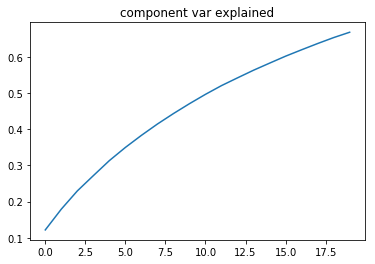

[0.12148586 0.05742347 0.05034639 0.04220369 0.04158565 0.03637164
 0.03337449 0.03130412 0.02888634 0.02731452 0.02585063 0.02411702
 0.02143185 0.02107956 0.01952254 0.01927034 0.0176845  0.01724398
 0.01642976 0.01478698]


In [11]:
# todo try pca to bring the dimensionality down


N_COMPONENTS = 20 # from inspection

pca = PCA(n_components=N_COMPONENTS) # 
pca.fit(status_embedding)

print(np.shape(pca.singular_values_))
print(np.shape(pca.components_))

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('component var explained')  # only the first ~40 components are making strong contributions ( >= ~1%)
plt.show()

print(pca.explained_variance_ratio_)

status_embedding_pca_compression = pca.transform(status_embedding)

#print(np.shape(status_embedding_pca_compression))
#print(status_embedding_pca_compression[0:100,:])

In [16]:
# ok this is too slow - need to troubleshoot or find another way



# run umap to crunch down the pca projection
'''
start = timer()

abstract_embedding_pca_umap_compression = umap.UMAP(
    n_neighbors=30, # 30 is probably a good value for clustering applications
    min_dist=0,
    n_components=10, # target_dimensionality
    random_state=42,
    metric='cosine'
).fit_transform(status_embedding_pca_compression)

end = timer()
print("time elapsed: ")
print(end - start)
'''

C:\Users\Brendan\Anaconda\envs\dimensionality_env\lib\site-packages\umap\rp_tree.py:712: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
C:\Users\Brendan\Anaconda\envs\dimensionality_env\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 389 connected components using meta-embedding (experimental)
  n_components

KeyboardInterrupt



In [2]:
# input is samples x features

clusterer = hdbscan.HDBSCAN(cluster_selection_method='leaf',min_samples=1,min_cluster_size=10) # cluster_selection_method='leaf',
labels = clusterer.fit_predict(status_embedding_pca_compression) # realized this return was available just now

print(clusterer.labels_.max())
N_clusters = clusterer.labels_.max()
cluster_labels = clusterer.labels_.tolist()

plt.figure()
plt.plot(clusterer.labels_)
plt.title('cluster labels')
plt.show()

plt.figure(figsize=(15,10))
clusterer.condensed_tree_.plot() #select_clusters=True,
                               # selection_palette=sns.color_palette('deep', 8))
plt.show()

cluster_sizes = dict((x,cluster_labels.count(x)) for x in set(cluster_labels))
#print(cluster_sizes)

NameError: name 'hdbscan' is not defined

In [13]:
for cluster_idx in range(N_clusters):
    print('articles for cluster ' + str(cluster_idx) + ':')
    
    # list the articles
    source_idxs = np.argwhere(labels==cluster_idx)[:,0] # flatten
    print(source_idxs)
    
    cluster_texts = []
    for source_idx in source_idxs:
        cluster_texts.append(list_of_sentences[source_idx])
    #print(cluster_texts)
    
    cluster_titles = []
    for source_idx in source_idxs:
        cluster_titles.append(df['status'].iloc[source_idx])
    print(cluster_titles)
    
    print(' ')
    print(' ')

articles for cluster 0:
[ 23486  35400  41559  53582  59514  65408  71034  79820  86043  98291
 104322 110469 116367 122441 128348 133000 139501 143555 148599 153732
 157492 160784 165097 167024 169313 171168 173248 175567 177459 179399
 182421 184290 186644 197995 204049 207613 210513 214100 217644 219739
 222559 224911 228041 233701 238686 254460 262825 270602 275516 281611
 287216 329612 330250 335358 354577 377561 400084]


KeyError: 'status'